spsc_0.999990 1000
spsc_0.999985 1000
spsc_0.999978 1000
spsc_0.999968 1000
spsc_0.999954 1000
spsc_0.999932 1000
spsc_0.999900 1000
spsc_0.999785 1000
spsc_0.999536 1000
spsc_0.999000 1000
spsc_0.997846 1000
spsc_0.995358 1000
spsc_0.990000 1000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


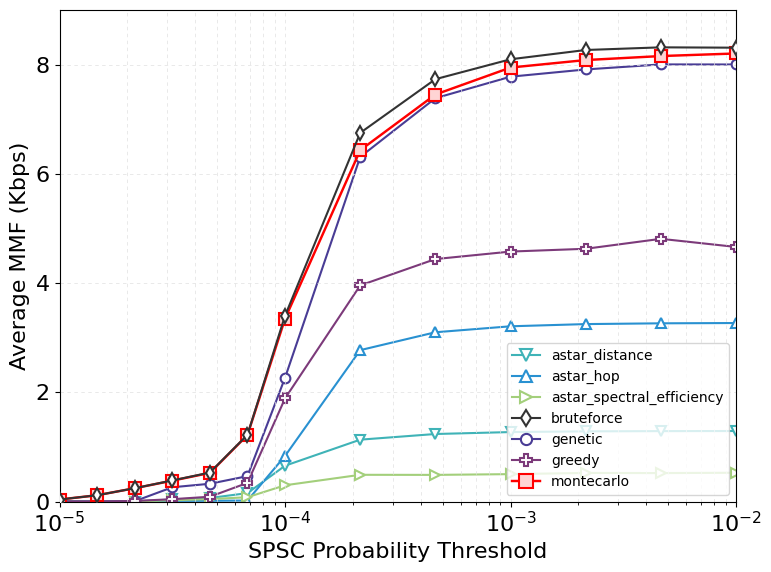

In [19]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

fontsize=16
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize

# astar_distance astar_hop astar_spectral_efficiency bruteforce genetic greedy montecarlo ??
marker_list = ['v', '^', '>', 'd', 'o', 'P', 's', 'X',]
color_list = ["#3FB3B7", "#2991D1", "#A3CF7B", "#333333", "#493C95", "#7C3A7A", "#FF0000"]
# Base directory where experiment results are saved
base_dir = "/fast/hslyu/mmf_result_3"

# Define thresholds from logspace
raw_logspace = np.concatenate(
    (np.logspace(-5, -4, 7, base=10)[:-1], np.logspace(-4, 0, 13, base=10)[:-6])
)
thresholds = 1 - raw_logspace  # Same as in main_experiment()

# Dictionary to store average throughput per scheme for each threshold
results_by_threshold = {}

# Loop through each threshold
for threshold in thresholds:
    threshold_str = f"spsc_{threshold:.6f}"
    thresh_path = os.path.join(base_dir, threshold_str)
    
    if not os.path.isdir(thresh_path):
        continue

    # Get all experiment directories within this threshold directory
    exp_dirs = [d for d in os.listdir(thresh_path) if d.startswith("exp_") and os.path.isdir(os.path.join(thresh_path, d))]
    print(threshold_str, len(exp_dirs))
    scheme_results = {}
    # Process each experiment
    for exp_dir in exp_dirs:
        result_file = os.path.join(thresh_path, exp_dir, "result.json")
        if os.path.isfile(result_file):
            with open(result_file, "r") as f:
                result_data = json.load(f)
            for scheme, throughput in result_data.items():
                if scheme not in scheme_results:
                    scheme_results[scheme] = []
                scheme_results[scheme].append(throughput)
        else:
            continue
            print(f"Result file not found: {result_file}")
    

    if scheme_results:
        if "bruteforce" in scheme_results and "montecarlo" in scheme_results and threshold >= 1-1e-4:
            # Align lengths by truncating to the shorter one
            min_len = min(len(scheme_results["bruteforce"]), len(scheme_results["montecarlo"]))
            bf_vals = np.array(scheme_results["bruteforce"][:min_len])
            mc_vals = np.array(scheme_results["montecarlo"][:min_len])
            # Elementwise maximum
            scheme_results["bruteforce"][:min_len] = np.maximum(bf_vals-1e3, mc_vals).tolist()

        avg_results = {scheme: np.mean(values) for scheme, values in scheme_results.items()}
        results_by_threshold[threshold] = avg_results

# Extract all unique scheme names across thresholds
all_schemes = set()
for res in results_by_threshold.values():
    all_schemes.update(res.keys())
all_schemes = sorted(list(all_schemes))

# Plot average throughput for each scheme as a function of threshold
plt.figure(figsize=(8, 6))
for i, scheme in enumerate(all_schemes):
    avg_throughputs = []
    for thresh in thresholds:
        val = results_by_threshold.get(thresh, {}).get(scheme, np.nan) / 1000
        avg_throughputs.append(val if val is not None else np.nan)

    zorder = 1
    linewidth = 1.5
    # if scheme != "bruteforce":
    #     markerfacecolor = "w"
    #     markersize = 7
    #     continue

    if scheme == "montecarlo":
        markerfacecolor = "#FFD4D4"
        linewidth = 1.75
        markersize = 8.5
        zorder=2
    elif scheme == "greedy":
        markerfacecolor = 'w'
        markersize = 7.5
    elif scheme == "bruteforce":
        zorder = 3
    else:
        markerfacecolor = "w"
        markersize = 7

    
    plt.plot(raw_logspace, 
             avg_throughputs, 
             linewidth=linewidth,
             marker=marker_list[i],
             markersize=markersize,
             markerfacecolor=markerfacecolor,
             markeredgewidth=1.5,
             color=color_list[i],
             label=scheme,
             zorder=zorder
             )

plt.xlim(min(raw_logspace), max(raw_logspace))
plt.xscale("log")
plt.xlabel("SPSC Probability Threshold")
plt.xticks()

plt.ylabel("Average MMF (Kbps)")
plt.ylim(0, 9)
plt.yticks(list(range(0, 9, 2)))
ax = plt.gca()
# ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# ax.yaxis.offsetText.set_text("×10³")

plt.legend(fontsize=10, loc='lower right', markerscale=1.15)
plt.grid(True, which='both', linestyle=(0, (5, 5)), linewidth=0.5, color="#e0e0e0")
plt.tight_layout()
# Save the figure as EPS, RGB color
fname = os.path.basename(os.path.normpath(base_dir))
plt.savefig(fname+".eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()